# Import Libraries

In [1]:
from librosa.core import load as ld_wav
from librosa.feature import delta
import librosa.feature as ft_extraction
import scipy.io.wavfile as wav
import numpy as np
import os
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,make_scorer,f1_score
from sklearn.model_selection import train_test_split,StratifiedKFold,cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.metrics.pairwise import euclidean_distances
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.utils.validation import check_is_fitted
!pip install scikit-optimize
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import seaborn as sns
import pandas as pd
import librosa
from operator import itemgetter
import pickle
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.metrics import AUC,Precision,Recall,BinaryCrossentropy,Accuracy
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Install pyspark and systemml

In [2]:
# instalar as dependências
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xf spark-2.4.4-bin-hadoop2.7.tgz
!pip install -q findspark
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"
 
# tornar o pyspark "importável"
import findspark
findspark.init('spark-2.4.4-bin-hadoop2.7')
!pip install elephas

In [3]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql.types import StructType, StructField, DoubleType, IntegerType, StringType
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .getOrCreate()
import time


# Data Extraction

In [4]:
!ls "/content/drive/My Drive/IRMAS-training"

best_params.txt		       fanova	    PCA		 resultados_CW
data_dict.pickle	       KPCA	    pia		 vio
data_dict_procVoz.pickle       MFCCresults  PNCC-master
data_dict_procVoz_pncc.pickle  Original     resultados


In [5]:
# directory where we your .wav files are
directoryName = "/content/drive/My Drive/IRMAS-training" # put your own directory here
#instruments to evaluate
instruments = ["pia","vio"]
# directory to put our results in, you can change the name if you like
resultsDirectory = directoryName + "/MFCCresults"


In [6]:
def countTrainTracks(input_path, labels):
		""" Counts the number of tracks in the folders of the trainset
		"""
		total = 0
		for l, label in enumerate(labels):
			instrument_dir = os.path.join(input_path, label)
			total += len(os.listdir(instrument_dir))

		return total

In [7]:
if not os.path.exists(resultsDirectory):
    os.makedirs(resultsDirectory)

In [8]:
total_tracks = countTrainTracks(directoryName,instruments)
print("Total tracks: ",total_tracks)

Total tracks:  1301


In [9]:
data_dict = dict()
data_dict["rolloff"] = list()
data_dict["bandwidth"] = list()
data_dict["centroids"] = list()
data_dict["zero_crossing_rate"] = list()
data_dict["rms"] = list()
data_dict["slope"] = list()
data_dict["kurtosis"] = list()
data_dict["skewness"] = list()
for i in range(0,13):
    data_dict["mfcc"+str(i)] = list()
data_dict["instrument"] = list()

In [10]:
#Essa funcao recebe cada coluna mfcc[j], que é um vetor onde cada elemento vetor[i]
#contem todos os K coeficientes mfcc[j] de um audio i. O objetivo é descobrir como os MFCC[j] mudam ao longo do tempo.
#Obs: 
#j (quantidade de coeficientes MFCC) = {0,13}, 
#k (quantidade de uma mesma caracteristica extraída do audio completo - depende do tamanho de janela e do tempo de duração) = {0,130}, 
#i (numero de arquivos do dataset) = 1301 
def getDeltaFeat(column):
    #Quantos vetores serão lidos, ou seja, o tamanho do dataset 
    original_len = len(column)
    deltas = list()
    for i in range(original_len):
      deltas.append(delta(column[i], order=1))
    return np.array(deltas)

In [11]:
def includeDeltaFeat(df):
    for i in range(0,13):
        df["delta_mfcc"+str(i)]=getDeltaFeat(df["mfcc"+str(i)])
    return df

In [12]:
def FeatureSpectralCentroid(X, f_s):

    isSpectrum = X.ndim == 1

    # X = X**2 removed for consistency with book

    norm = X.sum(axis=0, keepdims=True)
    norm[norm == 0] = 1

    vsc = np.dot(np.arange(0, X.shape[0]), X) / norm

    # convert from index to Hz
    vsc = vsc / (X.shape[0] - 1) * f_s / 2

    # if input is a spectrum, output scaler else if spectrogram, output 1d array
    vsc = np.squeeze(vsc) if isSpectrum else np.squeeze(vsc, axis=0)

    return vsc

In [13]:
def FeatureSpectralSpread(X, f_s):

    isSpectrum = X.ndim == 1
    if isSpectrum:
        X = np.expand_dims(X, axis=1)

    # get spectral centroid as index
    vsc = FeatureSpectralCentroid(X, f_s) * 2 / f_s * (X.shape[0] - 1)

    # X = X**2 removed for consistency with book

    norm = X.sum(axis=0)
    norm[norm == 0] = 1

    # compute spread
    vss = np.zeros(X.shape[1])
    indices = np.arange(0, X.shape[0])
    for n in range(0, X.shape[1]):
        vss[n] = np.dot((indices - vsc[n])**2, X[:, n]) / norm[n]

    vss = np.sqrt(vss)

    # convert from index to Hz
    vss = vss / (X.shape[0] - 1) * f_s / 2

    return np.squeeze(vss) if isSpectrum else vss

In [14]:
def FeatureSpectralKurtosis(X, f_s, UseBookDefinition=False):

    isSpectrum = X.ndim == 1
    if isSpectrum:
        X = np.expand_dims(X, axis=1)

    if UseBookDefinition:  # not recommended
        # compute mean and standard deviation
        mu_x = np.mean(X, axis=0, keepdims=True)
        std_x = np.std(X, axis=0)

        # remove mean
        X = X - mu_x

        # compute kurtosis
        vsk = np.sum(X**4, axis=0) / (std_x**4 * X.shape[0])
    else:
        f = np.arange(0, X.shape[0]) / (X.shape[0] - 1) * f_s / 2
        # get spectral centroid and spread (mean and std of dist)
        vsc = FeatureSpectralCentroid(X, f_s)  # *2/f_s * (X.shape[0]-1)
        vss = FeatureSpectralSpread(X, f_s)    # *2/f_s * (X.shape[0]-1)

        norm = X.sum(axis=0)
        norm[norm == 0] = 1
        vss[vss == 0] = 1

        # compute kurtosis
        vsk = np.zeros(X.shape[1])
        for n in range(0, X.shape[1]):
            vsk[n] = np.dot((f - vsc[n])**4, X[:, n]) / (vss[n]**4 * norm[n] * X.shape[0])

    return np.squeeze(vsk - 3) if isSpectrum else (vsk - 3)

In [15]:
def FeatureSpectralSkewness(X, f_s, UseBookDefinition=False):

    isSpectrum = X.ndim == 1
    if isSpectrum:
        X = np.expand_dims(X, axis=1)

    if UseBookDefinition:  # not recommended
        # compute mean and standard deviation
        mu_x = np.mean(X, axis=0, keepdims=True)
        std_x = np.std(X, axis=0)

        # remove mean
        X = X - mu_x

        # compute kurtosis
        vssk = np.sum(X**3, axis=0) / (std_x**3 * X.shape[0])
    else:
        f = np.arange(0, X.shape[0]) / (X.shape[0] - 1) * f_s / 2
        # get spectral centroid and spread (mean and std of dist)
        vsc = FeatureSpectralCentroid(X, f_s) 
        vss = FeatureSpectralSpread(X, f_s)   

        norm = X.sum(axis=0)
        norm[norm == 0] = 1
        vss[vss == 0] = 1

        # compute spread
        vssk = np.zeros(X.shape[1])
        for n in range(0, X.shape[1]):
            vssk[n] = np.dot((f - vsc[n])**3, X[:, n]) / (vss[n]**3 * norm[n] * X.shape[0])

    return np.squeeze(vssk) if isSpectrum else vssk

In [16]:
def FeatureSpectralSlope(X, f_s):

    # compute mean
    mu_x = X.mean(axis=0, keepdims=True)

    # compute index vector
    kmu = np.arange(0, X.shape[0]) - X.shape[0] / 2

    # compute slope
    X = X - mu_x
    vssl = np.dot(kmu, X) / np.dot(kmu, kmu)

    return vssl

In [17]:
(sig,rate) = ld_wav(directoryName +"/"+'pia'+"/" +'001__[pia][nod][cla]1389__1.wav')
spectogram = np.abs(librosa.stft(sig,n_fft=512))
feat = FeatureSpectralSlope(spectogram,rate)
print(np.array(feat).reshape(1,-1).shape)

(1, 517)


In [18]:
mfcc_feat = ft_extraction.mfcc(S=spectogram,sr=rate,n_mfcc=13)
mfcc_feat.shape

(13, 517)

In [19]:
ft_extraction.zero_crossing_rate(y=sig,frame_length=512,hop_length=512//4).shape

(1, 517)

In [20]:
len(sig)

66150

In [21]:
def zeroPadding(sig,wav_len = 66150):
  left_zeros = np.zeros(wav_len - sig.shape[0])
  return np.hstack([left_zeros,sig])

In [22]:
def getData(directoryName,instruments,data_dict):
    instrument_index = 0
    files_read = 0
    for instrument in instruments:
        for filename in os.listdir(directoryName+"/"+instrument):
            if filename.endswith('.wav'): # only get MFCCs from .wavs
                # read in our file
                (sig,rate) = ld_wav(directoryName +"/"+instrument+"/" +filename)
                sig = zeroPadding(sig)
                # get mfcc
                spectogram = np.abs(librosa.stft(sig,n_fft=512))
                mfcc_feat = ft_extraction.mfcc(S=spectogram,sr=rate,n_mfcc=13)
                rolloff_feat = ft_extraction.spectral_rolloff(S=spectogram,sr=rate)
                bandwidth_feat = ft_extraction.spectral_bandwidth(S=spectogram,sr=rate,)
                centroid_feat = ft_extraction.spectral_centroid(S=spectogram,sr=rate)
                zero_crossing_rate_feat = ft_extraction.zero_crossing_rate(y=sig,frame_length=512,hop_length=512//4)
                rms_feat = ft_extraction.rms(S=spectogram)
                slope_feat = FeatureSpectralSlope(spectogram,rate)
                slope_feat = np.array(slope_feat).reshape(1,-1)
                kurtosis_feat = FeatureSpectralKurtosis(spectogram,rate)
                kurtosis_feat = np.array(kurtosis_feat).reshape(1,-1)
                skewness_feat = FeatureSpectralSkewness(spectogram,rate)
                skewness_feat = np.array(skewness_feat).reshape(1,-1)
                data_dict["instrument"].append([instrument_index])
                for i in range(0,13):
                  data_dict["mfcc"+str(i)].append(mfcc_feat[i])
                data_dict["rolloff"].append(rolloff_feat[0])
                data_dict["bandwidth"].append(bandwidth_feat[0])
                data_dict["centroids"].append(centroid_feat[0])
                data_dict["zero_crossing_rate"].append(zero_crossing_rate_feat[0])
                data_dict["rms"].append(rms_feat[0])
                data_dict["slope"].append(slope_feat[0])
                data_dict["kurtosis"].append(kurtosis_feat[0])
                data_dict["skewness"].append(skewness_feat[0])
                # create a file to save our results in
                files_read += 1
        instrument_index += 1
    data_dict = includeDeltaFeat(data_dict)
    return data_dict                                                                                           

In [23]:
"""data_dict = getData(directoryName,instruments,data_dict)
with open(directoryName+"/data_dict_procVoz.pickle","wb") as f:
  pickle.dump(data_dict,f)"""

'data_dict = getData(directoryName,instruments,data_dict)\nwith open(directoryName+"/data_dict_procVoz.pickle","wb") as f:\n  pickle.dump(data_dict,f)'

In [24]:
with open(directoryName+"/data_dict_procVoz.pickle","rb") as f:
  data_dict = pickle.load(f)

In [25]:
len(data_dict["bandwidth"][0])

517

In [26]:
np.count_nonzero(~np.isnan(data_dict["mfcc0"]))

672617

In [27]:
for key in data_dict.keys():
    print(key,len(data_dict[key]))
    #convert list to np
    data_dict[key] = np.array(data_dict[key])

rolloff 1301
bandwidth 1301
centroids 1301
zero_crossing_rate 1301
rms 1301
slope 1301
kurtosis 1301
mfcc0 1301
mfcc1 1301
mfcc2 1301
mfcc3 1301
mfcc4 1301
mfcc5 1301
mfcc6 1301
mfcc7 1301
mfcc8 1301
mfcc9 1301
mfcc10 1301
mfcc11 1301
mfcc12 1301
instrument 1301
delta_mfcc0 1301
delta_mfcc1 1301
delta_mfcc2 1301
delta_mfcc3 1301
delta_mfcc4 1301
delta_mfcc5 1301
delta_mfcc6 1301
delta_mfcc7 1301
delta_mfcc8 1301
delta_mfcc9 1301
delta_mfcc10 1301
delta_mfcc11 1301
delta_mfcc12 1301


In [28]:
data_dict["rolloff"].shape[0]

1301

In [29]:
#Para o datafram não aceita matriz como input. Como cada arquivo de audio do data se obtem uma matriz de 
#tamanho (tam,n_features) multiplicaremos cada elemento do vetor de saída por esse tamanho. Assim, para um dado audio e para cada linha
#da matriz de dados teremos um valor de saída corresponde. A representação com matriz será util quando utilizarmos redes neurais
#O metodo flatten() transforma 2d arrays em 1d
data_for_df = dict()
data_for_df['instrument'] = list()
for key in data_dict.keys():
  if key != 'instrument':
    data_for_df[key] = data_dict[key].flatten()
    print("Feat {} has len {}".format(key,len(data_for_df[key])))
  else:
    for i in range(len(data_dict['instrument'])):
      data_for_df['instrument'].extend([data_dict['instrument'][i][0]] * len(data_dict['bandwidth'][i]))
df = pd.DataFrame.from_dict(data_for_df)

Feat rolloff has len 672617
Feat bandwidth has len 672617
Feat centroids has len 672617
Feat zero_crossing_rate has len 672617
Feat rms has len 672617
Feat slope has len 672617
Feat kurtosis has len 672617
Feat mfcc0 has len 672617
Feat mfcc1 has len 672617
Feat mfcc2 has len 672617
Feat mfcc3 has len 672617
Feat mfcc4 has len 672617
Feat mfcc5 has len 672617
Feat mfcc6 has len 672617
Feat mfcc7 has len 672617
Feat mfcc8 has len 672617
Feat mfcc9 has len 672617
Feat mfcc10 has len 672617
Feat mfcc11 has len 672617
Feat mfcc12 has len 672617
Feat delta_mfcc0 has len 672617
Feat delta_mfcc1 has len 672617
Feat delta_mfcc2 has len 672617
Feat delta_mfcc3 has len 672617
Feat delta_mfcc4 has len 672617
Feat delta_mfcc5 has len 672617
Feat delta_mfcc6 has len 672617
Feat delta_mfcc7 has len 672617
Feat delta_mfcc8 has len 672617
Feat delta_mfcc9 has len 672617
Feat delta_mfcc10 has len 672617
Feat delta_mfcc11 has len 672617
Feat delta_mfcc12 has len 672617


In [30]:
len(data_dict[key].flatten())

672617

In [31]:
517*1301

672617

(1301x130)x31

In [32]:
input_variables = list(df.columns)
input_variables.remove("instrument")
output_variable = "instrument"
print(input_variables)

['rolloff', 'bandwidth', 'centroids', 'zero_crossing_rate', 'rms', 'slope', 'kurtosis', 'mfcc0', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12', 'delta_mfcc0', 'delta_mfcc1', 'delta_mfcc2', 'delta_mfcc3', 'delta_mfcc4', 'delta_mfcc5', 'delta_mfcc6', 'delta_mfcc7', 'delta_mfcc8', 'delta_mfcc9', 'delta_mfcc10', 'delta_mfcc11', 'delta_mfcc12']


# Preprocessing

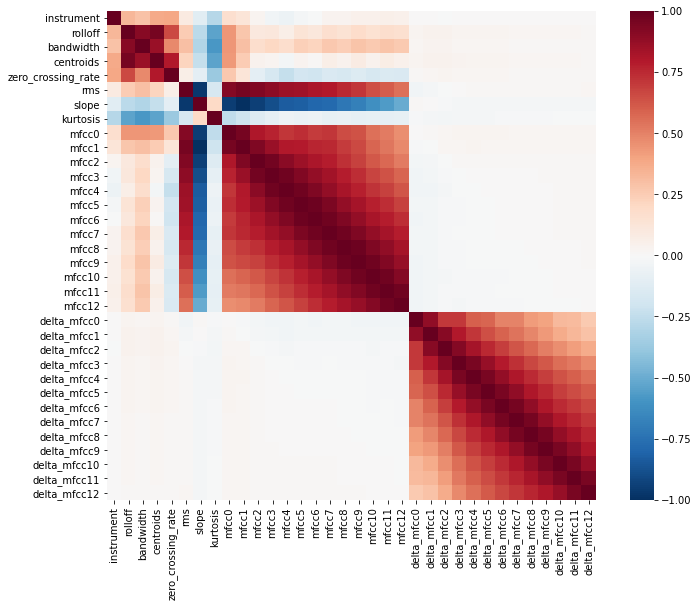

In [33]:
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat,cmap=sns.color_palette("RdBu_r", 1000), vmin=-1,vmax=1, square=True)
plt.savefig('CorrelationMatrix.png')
plt.show()

In [34]:
np.unique(df['instrument'])

array([0, 1])

In [35]:
df.shape

(672617, 34)

In [36]:
le = preprocessing.LabelEncoder()
le.fit(instruments)
print(le.inverse_transform([0,1]))

['pia' 'vio']


In [37]:
from pyspark.ml.feature import PCA,MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.linalg import Vectors
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [70]:
X_train, X_test, y_train, y_test = train_test_split(df[input_variables], df[output_variable], test_size=0.33, random_state=42)
#Transform to Spark DataFrame
df_train = map(lambda x: (int(x[0]), Vectors.dense(x[1:])), np.column_stack((y_train,X_train)))
df_train = spark.createDataFrame(df_train,schema=["label", "features"])
df_test = map(lambda x: (int(x[0]), Vectors.dense(x[1:])), np.column_stack((y_test,X_test)))
df_test = spark.createDataFrame(df_test,schema=["label", "features"])

In [ ]:
#Apply Min-Max Scaler
mmScaler = MinMaxScaler(inputCol="features", outputCol="scaled")
#Apply PCA
pca = PCA(k=10, inputCol=mmScaler.getOutputCol(), outputCol="pca_features")
#Set Classifier
rf = RandomForestClassifier(labelCol="label", featuresCol=pca.getOutputCol(), numTrees=10)
pipeline = Pipeline(stages=[mmScaler, pca, rf])
model = pipeline.fit(df_train)

Py4JJavaError: ignored

----------------------------------------ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "spark-2.4.4-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1159, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "spark-2.4.4-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 985, in send_command
    response = connection.send_command(command)
  File "spark-2.4.4-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1164, in send_command
    "Error while receiving", e, proto.ERROR_ON_RECEIVE)
py4j.protocol.Py4JNetworkError: Error while receiving

Exception happened during processing of request from ('127.0.0.1', 56062)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.

In [72]:
prediction = model.transform(df_test)

AttributeError: ignored

# Random Forest

In [73]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
evaluator.evaluate(prediction,{evaluator.metricName: "areaUnderPR"})

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:41225)
Traceback (most recent call last):
  File "spark-2.4.4-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "spark-2.4.4-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1067, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [Errno 111] Connection refused


Py4JNetworkError: ignored

# Neural Networks 

In [38]:
#Converter o dicionario para uma unica matriz concatenando os arrays em colunas
X = np.array([data_dict[key] for key in input_variables])
Y = data_dict['instrument'].flatten()
# Anteriormente para cada conjunto de caracteristicas extraídas efetuamos a classificação. Logo tinhamos vetores de tamanho n_features 
# Agora, para uma determina sequencia de caracteristicas extraidas efetuaremos a classificação. Logo teremos agora uma matrix:
# (tam_seq,n_features). Consideraremos cada linha dessa matriz sendo o tempo
#X.shape == (31,1301,130)
#Mas queremos que X.shape = (1301,130,31)
X = np.array([A.flatten() for A in np.transpose(X,(1,2,0))])
X_train, X_test, y_train, y_test = train_test_split(X,Y,
                                                    test_size=0.33,
                                                    random_state=42)


In [39]:
df_train = map(lambda x: (int(x[0]), Vectors.dense(x[1:])), np.column_stack((y_train,X_train)))
df_train = spark.createDataFrame(df_train,schema=["label", "features"])
df_test = map(lambda x: (int(x[0]), Vectors.dense(x[1:])), np.column_stack((y_test,X_test)))
df_test = spark.createDataFrame(df_test,schema=["label", "features"])

In [40]:
from elephas.spark_model import SparkModel
from elephas.utils.rdd_utils import to_simple_rdd
from elephas.ml_model import ElephasEstimator
from tensorflow.keras import optimizers

WARNING


In [41]:
#rdd = to_simple_rdd(sc, X_train, y_train)
opt = optimizers.Adam(lr=0.01)

In [63]:
def get_CNN_Model(input_shape):
    model = Sequential()
    model.add(layers.Reshape((517,33,1), input_shape=(input_shape,) ) )
    assert model.output_shape == (None, 517, 33, 1)
    model.add(layers.Conv2D(32,(3,3),activation='relu',padding="same",strides=(1,1)))
    model.add(layers.MaxPooling2D((2,2),padding='same'))
    model.add(layers.Conv2D(64,(3,3),activation='relu',padding="same",strides=(1,1)))
    model.add(layers.MaxPooling2D((2,2),padding='same'))
    model.add(layers.Conv2D(64,(3,3),activation='relu',padding="same",strides=(1,1)))
    model.add(layers.MaxPooling2D((2,2),padding='same'))
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(64,activation='relu'))
    model.add(layers.Dense(2,activation='softmax'))
    #model.summary()
    #model.compile(optimizer=opt,loss='binary_crossentropy')
    return model

In [64]:
X_train.shape[1]

17061

In [65]:
inp = X_train.shape[1]
#inp.append(1)
model = get_CNN_Model(inp)
model.compile(optimizer=opt,loss='categorical_crossentropy')
opt_conf = optimizers.serialize(opt)
# Initialize SparkML Estimator and set all relevant properties
estimator = ElephasEstimator()
estimator.setFeaturesCol("features")             # These two come directly from pyspark,
estimator.setLabelCol("label")                 # hence the camel case. Sorry :)
estimator.set_keras_model_config(model.to_yaml())       # Provide serialized Keras model
estimator.set_categorical_labels(True)
estimator.set_nb_classes(2)
estimator.set_num_workers(1)  # We just use one worker here. Feel free to adapt it.
estimator.set_epochs(20) 
estimator.set_batch_size(32)
estimator.set_verbosity(1)
estimator.set_validation_split(0.15)
estimator.set_optimizer_config(opt_conf)
estimator.set_mode("synchronous")
estimator.set_loss("categorical_crossentropy")
estimator.set_metrics(['acc'])

ElephasEstimator_e0340e0c5a79

In [66]:
fitted = estimator.fit(df_train)

>>> Fit model
>>> Synchronous training complete.


In [67]:
prediction = fitted.transform(df_test) # Evaluate on train data.
pnl = prediction.select("label", "prediction")
pnl.show(10)

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       1.0|
|  1.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  1.0|       0.0|
|  0.0|       0.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 10 rows



In [68]:
prediction.show()

+-----+--------------------+----------+
|label|            features|prediction|
+-----+--------------------+----------+
|  0.0|[3617.578125,2275...|       1.0|
|  1.0|[3617.578125,2083...|       0.0|
|  0.0|[1851.85546875,24...|       0.0|
|  0.0|[1076.66015625,15...|       0.0|
|  1.0|[2842.3828125,236...|       0.0|
|  0.0|[1679.58984375,13...|       0.0|
|  1.0|[8010.3515625,314...|       1.0|
|  1.0|[3875.9765625,187...|       1.0|
|  1.0|[1851.85546875,14...|       0.0|
|  0.0|[3703.7109375,196...|       0.0|
|  1.0|[2153.3203125,133...|       0.0|
|  1.0|[2282.51953125,16...|       0.0|
|  1.0|[2928.515625,1482...|       1.0|
|  1.0|[3143.84765625,17...|       0.0|
|  1.0|[3057.71484375,17...|       1.0|
|  0.0|[2627.05078125,16...|       1.0|
|  1.0|[2670.1171875,148...|       0.0|
|  0.0|[1765.72265625,12...|       0.0|
|  0.0|[990.52734375,755...|       0.0|
|  0.0|[1205.859375,1089...|       0.0|
+-----+--------------------+----------+
only showing top 20 rows



In [69]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction")
evaluator.evaluate(prediction,{evaluator.metricName: "areaUnderPR"})

0.6904702197605768